# Importing the libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
import io
import os
from datetime import datetime
import pandas as pd
from skimage.io.collection import ImageCollection
from skimage.io import imread
from skimage.io import imshow
from skimage.io import imsave

print (tf.__version__)

2.4.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Importing the dataset

## Training Set

In [3]:
os.chdir('E:\\Cancer Project\\Labelled_Dataset_1')

In [5]:
Batch_size = 32
Image_size = (224,224)


training_set = tf.keras.preprocessing.image_dataset_from_directory(directory = 'Train_set',
                                                                  batch_size = Batch_size,
                                                                  image_size = Image_size,
                                                                  label_mode = 'categorical')

Found 33696 files belonging to 7 classes.


### Visualizing the results

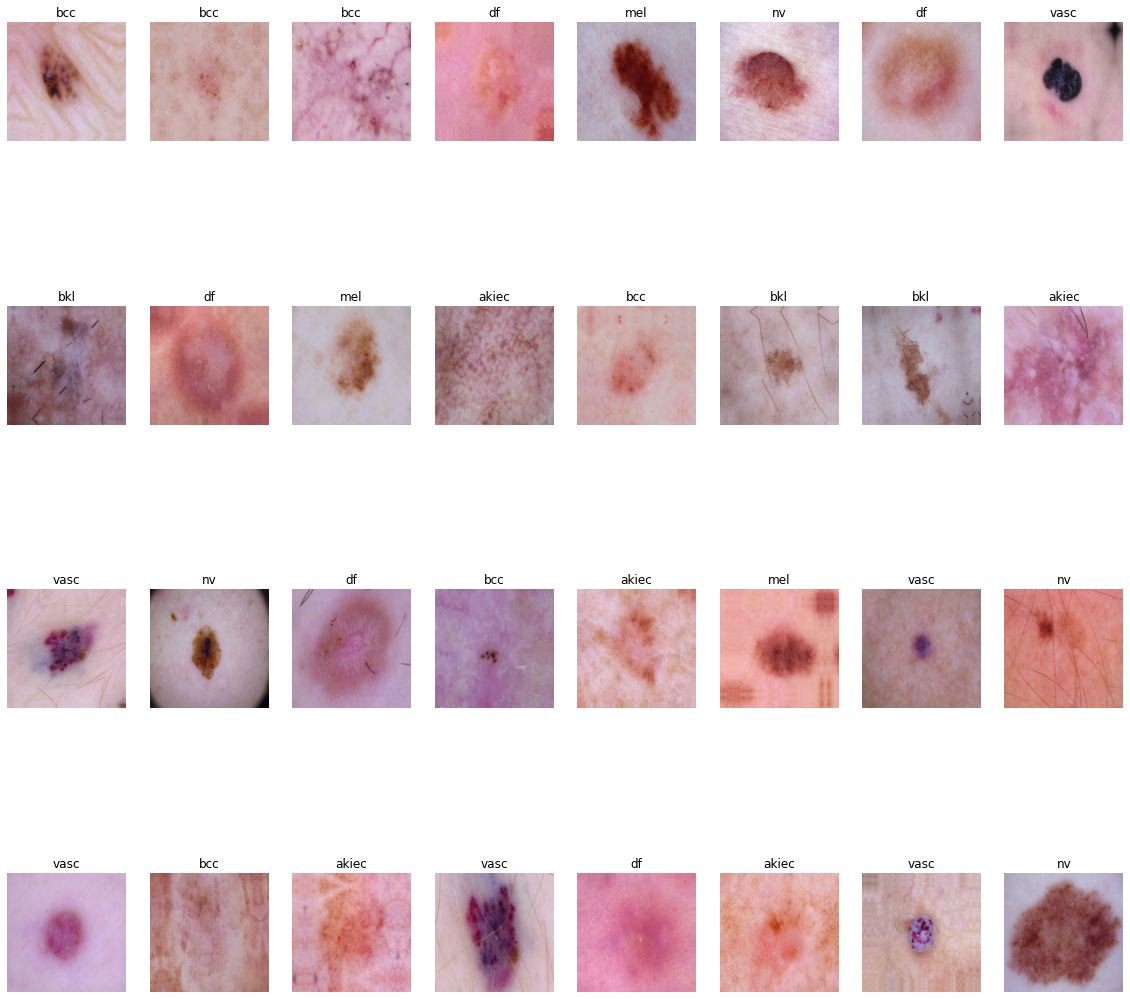

In [6]:
class_names = training_set.class_names

plt.figure(figsize = (20,20))

for image, label in training_set.take(1):
    for i in range(0,32):
        plt.subplot(4,8,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[np.where(label[i].numpy() ==1)[0][0]])
        plt.axis('off')
        
plt.show()

## Test set

In [7]:
Batch_size = 32
Image_size = (224,224)


test_set = tf.keras.preprocessing.image_dataset_from_directory(directory = 'Test_set',
                                                               batch_size = Batch_size,
                                                               image_size = Image_size,
                                                               label_mode = 'categorical')

Found 2003 files belonging to 7 classes.


### Splitting the Test set into the Validation Set and Test Set

In [8]:
val_batches = test_set.cardinality()

validation_set = test_set.take(val_batches//5)

test_set = test_set.skip(val_batches//5)

print('Number of batches (Test_Set):', '', test_set.cardinality().numpy())
print ('')
print('Number of batches (Validation_Set):', '', validation_set.cardinality().numpy())

Number of batches (Test_Set):  51

Number of batches (Validation_Set):  12


### Configure the data to improve performance

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

training_set = training_set.prefetch(buffer_size = AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size = AUTOTUNE)
test_set = test_set.prefetch(buffer_size = AUTOTUNE)

# Data Augmentation

In [10]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                                        tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
                                        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
                                        tf.keras.layers.experimental.preprocessing.RandomZoom(-0.3),
                                        tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1)])

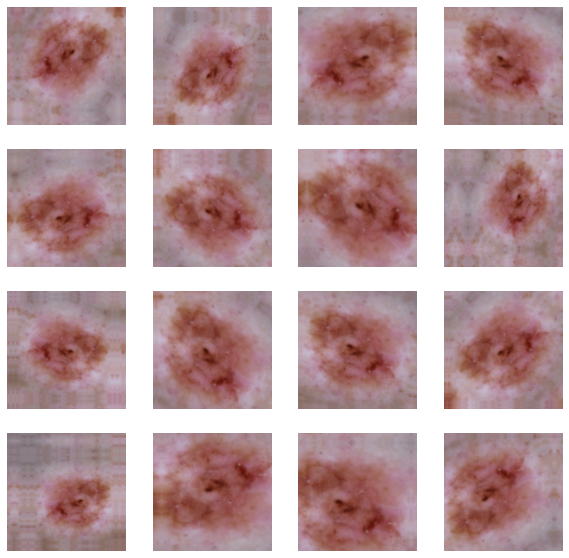

In [11]:
plt.figure(figsize = (10,10))

for image, label in training_set.take(1):
    im = image[1]
    for i in range(0,16):
        plt.subplot(4,4,1+i)
        augemented_image = data_augmentation(tf.expand_dims(im,0))
        plt.imshow(augemented_image[0]/255)
        plt.axis('off')
plt.show()

In [12]:
data_augmentation.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./127.5, offset = -1))

# Building the CNN

In [13]:
Input_shape_bm = Image_size + (3,)

Backbone_model = tf.keras.applications.VGG16(input_shape = Input_shape_bm,
                                             include_top = False,
                                             weights = 'imagenet')

In [14]:
Backbone_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
# Checking the shape of the output from the backbone model

image_batch, label_batch = next(iter(training_set))
feature_batch = Backbone_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [15]:
print ('Number of Layers in the backbone model:', '', len(Backbone_model.layers))

Number of Layers in the backbone model:  19


We will only train the top 9 layers of the backbone model

In [16]:
Number_of_untrained_layers = 10

for i in Backbone_model.layers[:Number_of_untrained_layers]:
    i.trainable = False

In [17]:
Backbone_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Building the model

In [18]:
inputs = tf.keras.Input(shape = Input_shape_bm)
x = data_augmentation(inputs)
x = Backbone_model(x, training = False)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units = 128, activation = 'relu')(x)
x = tf.keras.layers.Dropout(rate = 0.2)(x)
outputs = tf.keras.layers.Dense(units = 7, activation = 'softmax')(x)

base_model = tf.keras.Model(inputs, outputs)

In [19]:
# Checking the shape of the output from the model

image_batch, label_batch = next(iter(training_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7)


In [20]:
base_learning_rate = 10e-5

base_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

In [21]:
base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [22]:
#Evaluating the half-baked model on the validation set prior to training it
loss0, accuracy0 = base_model.evaluate(validation_set)

12/12 [==============================] - 11s 203ms/step - loss: 1.6634 - accuracy: 0.1433


In [23]:
checkpoint_path = 'E:\\Cancer Project\\Saved_model\\VGG_16\\Checkpoints_2\\cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only = True,
    save_freq = 'epoch')

In [24]:
history = base_model.fit(x = training_set, validation_data = validation_set, epochs = 50, 
                        callbacks = [cp_callback])

Epoch 1/50
1053/1053 [==============================] - 446s 421ms/step - loss: 1.0004 - accuracy: 0.6267 - val_loss: 0.6272 - val_accuracy: 0.7786

Epoch 00001: saving model to E:\Cancer Project\Saved_model\VGG_16\Checkpoints_2\cp-0001.ckpt
Epoch 2/50
1053/1053 [==============================] - 245s 233ms/step - loss: 0.6532 - accuracy: 0.7552 - val_loss: 0.7376 - val_accuracy: 0.7474

Epoch 00002: saving model to E:\Cancer Project\Saved_model\VGG_16\Checkpoints_2\cp-0002.ckpt
Epoch 3/50
1053/1053 [==============================] - 247s 234ms/step - loss: 0.5126 - accuracy: 0.8096 - val_loss: 0.7889 - val_accuracy: 0.7526

Epoch 00003: saving model to E:\Cancer Project\Saved_model\VGG_16\Checkpoints_2\cp-0003.ckpt
Epoch 4/50
1053/1053 [==============================] - 247s 234ms/step - loss: 0.4413 - accuracy: 0.8362 - val_loss: 0.7392 - val_accuracy: 0.7786

Epoch 00004: saving model to E:\Cancer Project\Saved_model\VGG_16\Checkpoints_2\cp-0004.ckpt
Epoch 5/50
1053/1053 [==========

Epoch 35/50
1053/1053 [==============================] - 253s 240ms/step - loss: 0.0819 - accuracy: 0.9729 - val_loss: 1.4662 - val_accuracy: 0.8073

Epoch 00035: saving model to E:\Cancer Project\Saved_model\VGG_16\Checkpoints_2\cp-0035.ckpt
Epoch 36/50
1053/1053 [==============================] - 254s 240ms/step - loss: 0.0753 - accuracy: 0.9755 - val_loss: 1.9832 - val_accuracy: 0.7969

Epoch 00036: saving model to E:\Cancer Project\Saved_model\VGG_16\Checkpoints_2\cp-0036.ckpt
Epoch 37/50
1053/1053 [==============================] - 254s 240ms/step - loss: 0.0814 - accuracy: 0.9715 - val_loss: 2.0279 - val_accuracy: 0.7526

Epoch 00037: saving model to E:\Cancer Project\Saved_model\VGG_16\Checkpoints_2\cp-0037.ckpt
Epoch 38/50
1053/1053 [==============================] - 254s 241ms/step - loss: 0.0793 - accuracy: 0.9748 - val_loss: 2.1093 - val_accuracy: 0.7708

Epoch 00038: saving model to E:\Cancer Project\Saved_model\VGG_16\Checkpoints_2\cp-0038.ckpt
Epoch 39/50
1053/1053 [=====

# Visualizing the results

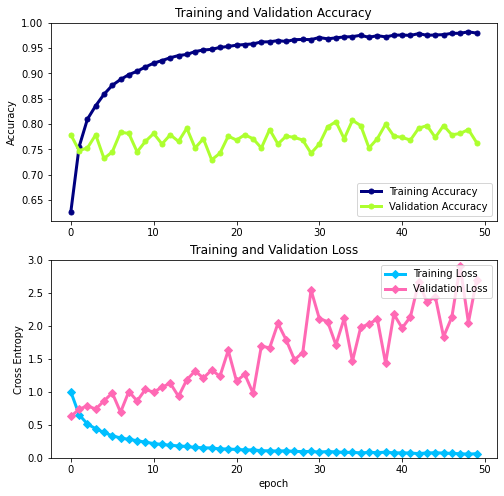

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth = 3, marker = 'o', ms = 5, color = 'navy')
plt.plot(val_acc, label='Validation Accuracy',linewidth = 3, marker = 'o', ms = 5, color = 'greenyellow')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss',linewidth = 3, marker = 'D', ms = 5, color = 'deepskyblue')
plt.plot(val_loss, label='Validation Loss',linewidth = 3, marker = 'D', ms = 5, color = 'hotpink')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
print ('Epoch with minimum Val_loss:', '' , np.where(np.array(val_loss) == min(val_loss))[0][0])

Epoch with minimum Val_loss:  0


# Reloading the weights which corresspond to different epochs and evaluating on the Validation set and Test set 

### The epoch selected was the one that gave the best accuracy on both sets

In [29]:
base_model.load_weights('E:\\Cancer Project\\Saved_model\\VGG_16\\Checkpoints_2\\cp-0006.ckpt')

In [31]:
#Evaluating the full-baked model on the validation set psost reloading the weights with the lowest validation loss
loss0, accuracy0 = base_model.evaluate(validation_set)

12/12 [==============================] - 3s 164ms/step - loss: 0.9035 - accuracy: 0.7682


In [32]:
#Evaluating the full-baked model on the Test set psost reloading the weights with the lowest validation loss
loss0, accuracy0 = base_model.evaluate(test_set)

51/51 [==============================] - 23s 401ms/step - loss: 0.8365 - accuracy: 0.7708


# Save the model

In [33]:
os.chdir('E:\\Cancer Project\\Saved_model\\VGG_16')

In [34]:
base_model.save('VGG-16_skin_cancer_1.h5')